In [28]:
from __future__ import print_function

import time
from PIL import Image

import numpy as np

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b

In [30]:
import cv2

img = cv2.imread('madam.jpg')
img.shape

(939, 561, 3)

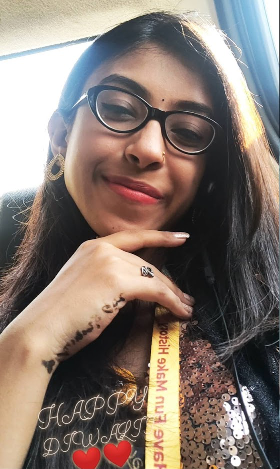

In [32]:
height = 939//2
width = 561//2

content_image_path = 'madam.jpg'
content_image = Image.open(content_image_path)
content_image = content_image.resize((width,height))
content_image

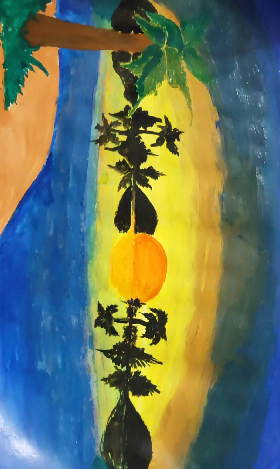

In [33]:
style_image_path = 'painting_chhotu.jpg'
style_image = Image.open(style_image_path)
style_image = style_image.resize((width,height))
style_image

In [34]:
content_array = np.asarray(content_image, dtype='float')
content_array = np.expand_dims(content_array, axis=0)
print(content_array.shape)

style_array = np.asarray(style_image, dtype='float')
style_array = np.expand_dims(style_array, axis=0)
print(style_array.shape)

(1, 469, 280, 3)
(1, 469, 280, 3)


In [35]:
#Subtract the mean RGB value (computed previously on the ImageNet training set and
#easily obtainable from Google searches) from each pixel.
content_array[:, :, :, 0] -= 103.939 #mean R value # these are all the mean rgb values
content_array[:, :, :, 1] -= 116.779 # mean G value
content_array[:, :, :, 2] -= 123.68  # mean B value

#Flip the ordering of the multi-dimensional array from RGB to BGR.
content_array = content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68

#Flip the ordering of the multi-dimensional array from RGB to BGR.
style_array = style_array[:, :, :, ::-1]

In [36]:
# Now we’re ready to use these arrays to define variables in Keras’ backend
# (the TensorFlow graph). We also introduce a placeholder variable to store
# the combination image that retains the content of the content_image while
# incorporating the style of the style_image. 
# (backend here is basically the tensorflow backend)

content_image = backend.variable(content_array)
style_image = backend.variable(style_array)
combination_image = backend.placeholder((1, height, width,3))

In [37]:
print(content_image) # here this is a tf variable

<tf.Variable 'Variable:0' shape=(1, 469, 280, 3) dtype=float32, numpy=
array([[[[  29.32 ,   64.221,   88.061],
         [  32.32 ,   67.221,   91.061],
         [  37.32 ,   72.221,   96.061],
         ...,
         [ 131.32 ,  138.221,  150.061],
         [ 131.32 ,  138.221,  150.061],
         [ -47.68 ,  -42.779,  -30.939]],

        [[  34.32 ,   69.221,   93.061],
         [  37.32 ,   72.221,   96.061],
         [  42.32 ,   77.221,  101.061],
         ...,
         [ 131.32 ,  138.221,  150.061],
         [ 131.32 ,  138.221,  150.061],
         [ -47.68 ,  -42.779,  -30.939]],

        [[  28.32 ,   63.221,   87.061],
         [  26.32 ,   61.221,   85.061],
         [  43.32 ,   78.221,  102.061],
         ...,
         [ 131.32 ,  138.221,  150.061],
         [ 131.32 ,  138.221,  150.061],
         [ -47.68 ,  -42.779,  -30.939]],

        ...,

        [[  35.32 ,   72.221,  112.061],
         [  34.32 ,   71.221,  111.061],
         [  34.32 ,   71.221,  111.061],
      

In [38]:
# Finally, we concatenate all this image data into a single tensor that’s suitable
# for processing by Keras’ VGG16 model.
input_tensor = backend.concatenate([content_image, style_image, combination_image], axis=0)

In [39]:
input_tensor # it is a tensor with dimensions below, having info
# for all the three images

<tf.Tensor 'concat_1:0' shape=(3, 469, 280, 3) dtype=float32>

In [40]:
model = VGG16(input_tensor = input_tensor, weights = 'imagenet', include_top=False)
# Note that by setting (include_top=False) in the code below, 
# we don’t include any of the fully-connected layers.

In [41]:
layers= dict([(layer.name,layer.output) for layer in model.layers])
layers

{'input_2': <tf.Tensor 'concat_1:0' shape=(3, 469, 280, 3) dtype=float32>,
 'block1_conv1': <tf.Tensor 'block1_conv1_1/Relu:0' shape=(3, 469, 280, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2_1/Relu:0' shape=(3, 469, 280, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool_1/MaxPool:0' shape=(3, 234, 140, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1_1/Relu:0' shape=(3, 234, 140, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2_1/Relu:0' shape=(3, 234, 140, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool_1/MaxPool:0' shape=(3, 117, 70, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1_1/Relu:0' shape=(3, 117, 70, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2_1/Relu:0' shape=(3, 117, 70, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3_1/Relu:0' shape=(3, 117, 70, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool_1/MaxPool:0' shape=(3, 58, 35, 256) dtype=float32>,
 

In [42]:
# in the above code, Notice also that because 
# we provided Keras with a concrete input tensor

# The crux of the paper we’re trying to reproduce is that the 
# style transfer problem can be posed as an optimisation problem, 
# where the loss function we want to minimise can be decomposed into 
# three distinct parts: the content loss, the style loss and the
# total variation loss.

White Noise -> White noise is a type of noise that is produced by combining sounds of all different frequencies together.

so in this context the white noise is the output combination image of any layer(which in our case is the 2nd layer)

In [43]:
content_weight = 0.025
style_weight = 5.0
total_variation_weight = 1.0

loss = backend.variable(0.) # initializing the total loss to 0.0


### Content Loss

In [44]:
# for the content loss
def content_loss(content, combination):
    return backend.sum(backend.square(combination-content))

# here we are extracting the feature of the given input from layer-2
# so that we can compare them to get the total loss in features of the 
# content and the combination image

# here our input has all three images i.e., content_image features,
# style image features and also the combination image feature

# here the one on the 0th position is the content 
# the one on the 1st position is the style
# and the last one on the 2nd position is the combination which
# we have used in the below code to find the content_loss

layer_features = layers['block2_conv2']
content_image_features = layer_features[0,:,:,:]
combination_features = layer_features[2,:,:,:]
loss = loss + content_weight * content_loss(content_image_features,
                                      combination_features)

### Style Loss

The Gram matrix can be computed efficiently by reshaping the feature spaces suitably and taking an outer product

In [45]:
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x,(2,0,1)))
#     batch_flatten=Turn a nD tensor into a 2D tensor with same 0th dimension.
#     In other words, it flattens each data samples of a batch.
# permute_dimensions = Permutes axes in a tensor, as 0 is for columns, 1 is for
# rows and 2 is for colour channels
    gram = backend.dot(features, backend.transpose(features))
    return gram

#### Calculating the style loss

In [46]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']
for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl

### Total Variation Loss

In [47]:
def total_variation_loss(x):
    a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

loss += total_variation_weight * total_variation_loss(combination_image)

In [48]:
grads = backend.gradients(loss, combination_image)

In [49]:
outputs = [loss]
outputs += grads
f_outputs = backend.function([combination_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

Now we’re finally ready to solve our optimisation problem. This combination image begins its life as a random collection of (valid) pixels, and we use the L-BFGS algorithm (a quasi-Newton algorithm that’s significantly quicker to converge than standard gradient descent) to iteratively improve upon it.

In [50]:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

iterations = 15

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 174950530000.0
Iteration 0 completed in 64s
Start of iteration 1
Current loss value: 48256004000.0
Iteration 1 completed in 63s
Start of iteration 2
Current loss value: 23297667000.0
Iteration 2 completed in 65s
Start of iteration 3
Current loss value: 16396868000.0
Iteration 3 completed in 66s
Start of iteration 4
Current loss value: 13225208000.0
Iteration 4 completed in 66s
Start of iteration 5
Current loss value: 11754407000.0
Iteration 5 completed in 66s
Start of iteration 6
Current loss value: 10503338000.0
Iteration 6 completed in 65s
Start of iteration 7
Current loss value: 9824412000.0
Iteration 7 completed in 66s
Start of iteration 8
Current loss value: 9372974000.0
Iteration 8 completed in 65s
Start of iteration 9
Current loss value: 9035050000.0
Iteration 9 completed in 65s
Start of iteration 10
Current loss value: 8784456000.0
Iteration 10 completed in 66s
Start of iteration 11
Current loss value: 8601147000.0
Iteration 11 completed

In [51]:
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

In [52]:
result = Image.fromarray(x)

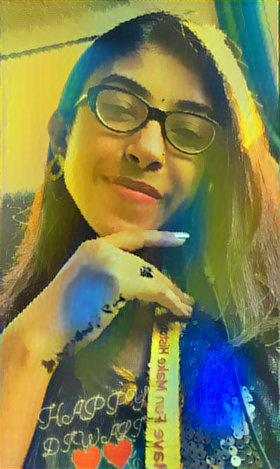

In [53]:
result

In [55]:
result.save("Resulting_image/retard.jpeg","JPEG")